In [1]:
from utils.utils import load_conversation_template
template_name = 'llama-2'
conv_template = load_conversation_template(template_name)

In [2]:
from utils.modelUtils import *
from utils.utils import *
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from casper import nethook


In [3]:
model_name ="/root/autodl-tmp/base/model"  # or "Llama2-7B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
    device = 'cuda:0'
)
mt.model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [4]:
test_prompt = generate_input(conv_template,"What is your name?")
predict_token(
    mt,
    [test_prompt],
    return_p=True,
    
)


(['Hello'], tensor([0.9984], device='cuda:0'))

In [5]:
generate_outputs(test_prompt,mt,)

["Hello! My name is Assistant, and I'm here to help you with any questions or concerns you may have. I'm just an AI, I don't have a personal name, but I'm here to assist you in a helpful, respectful, and honest manner. Is there anything else I can help you with?"]

In [6]:
test_prompt

"<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n<</SYS>>\n\nWhat is your name?.[/INST] "

In [7]:
def trace_with_patch_layer(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect  
):
    prng = np.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    layers = [states_to_patch[0], states_to_patch[1]]

    # Create dictionary to store intermediate results
    inter_results = {}

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer not in layers:
            return x

        if layer == layers[0]:
            inter_results["hidden_states"] = x[0].cpu()
            inter_results["attention_mask"] = x[1][0].cpu()
            inter_results["position_ids"] = x[1][1].cpu()
            return x
        elif layer == layers[1]:
            short_cut_1 = inter_results["hidden_states"].cuda()
            short_cut_2_1 = inter_results["attention_mask"].cuda()
            short_cut_2_2 = inter_results["position_ids"].cuda()
            short_cut_2 = (short_cut_2_1, short_cut_2_2)
            short_cut = (short_cut_1, short_cut_2)
            return short_cut
            
    with torch.no_grad(), nethook.TraceDict(
        model,
        layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

In [8]:
import matplotlib.pyplot as plt
def analyse_based_on_layer(prompt,):
    inp = make_inputs(mt.tokenizer,[prompt]*2)
    with torch.no_grad():
        answer_t, logits = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    print(answer)
    model = mt.model
    result_prob = []
    for layer in range(mt.num_layers-1):
        layers = [layername(model, layer),layername(model, layer + 1)]
        print(layers)
        prob =  trace_with_patch_layer(model, inp, layers,answer_t)
        result_prob.append(prob)
     # Convert tensors to a list of numbers
    data_on_cpu = [abs(x.item() - logits.item()) for x in result_prob]
    # Create a list of indices for x-axis
        
    return logits.item() ,data_on_cpu

In [9]:
logits, layerAIE = analyse_based_on_layer(test_prompt)

Hello
['model.layers.0', 'model.layers.1']
['model.layers.1', 'model.layers.2']
['model.layers.2', 'model.layers.3']
['model.layers.3', 'model.layers.4']
['model.layers.4', 'model.layers.5']
['model.layers.5', 'model.layers.6']
['model.layers.6', 'model.layers.7']
['model.layers.7', 'model.layers.8']
['model.layers.8', 'model.layers.9']
['model.layers.9', 'model.layers.10']
['model.layers.10', 'model.layers.11']
['model.layers.11', 'model.layers.12']
['model.layers.12', 'model.layers.13']
['model.layers.13', 'model.layers.14']
['model.layers.14', 'model.layers.15']
['model.layers.15', 'model.layers.16']
['model.layers.16', 'model.layers.17']
['model.layers.17', 'model.layers.18']
['model.layers.18', 'model.layers.19']
['model.layers.19', 'model.layers.20']
['model.layers.20', 'model.layers.21']
['model.layers.21', 'model.layers.22']
['model.layers.22', 'model.layers.23']
['model.layers.23', 'model.layers.24']
['model.layers.24', 'model.layers.25']
['model.layers.25', 'model.layers.26']

Text(0.7, 0.03, 'Kurtosis: 7.8646')

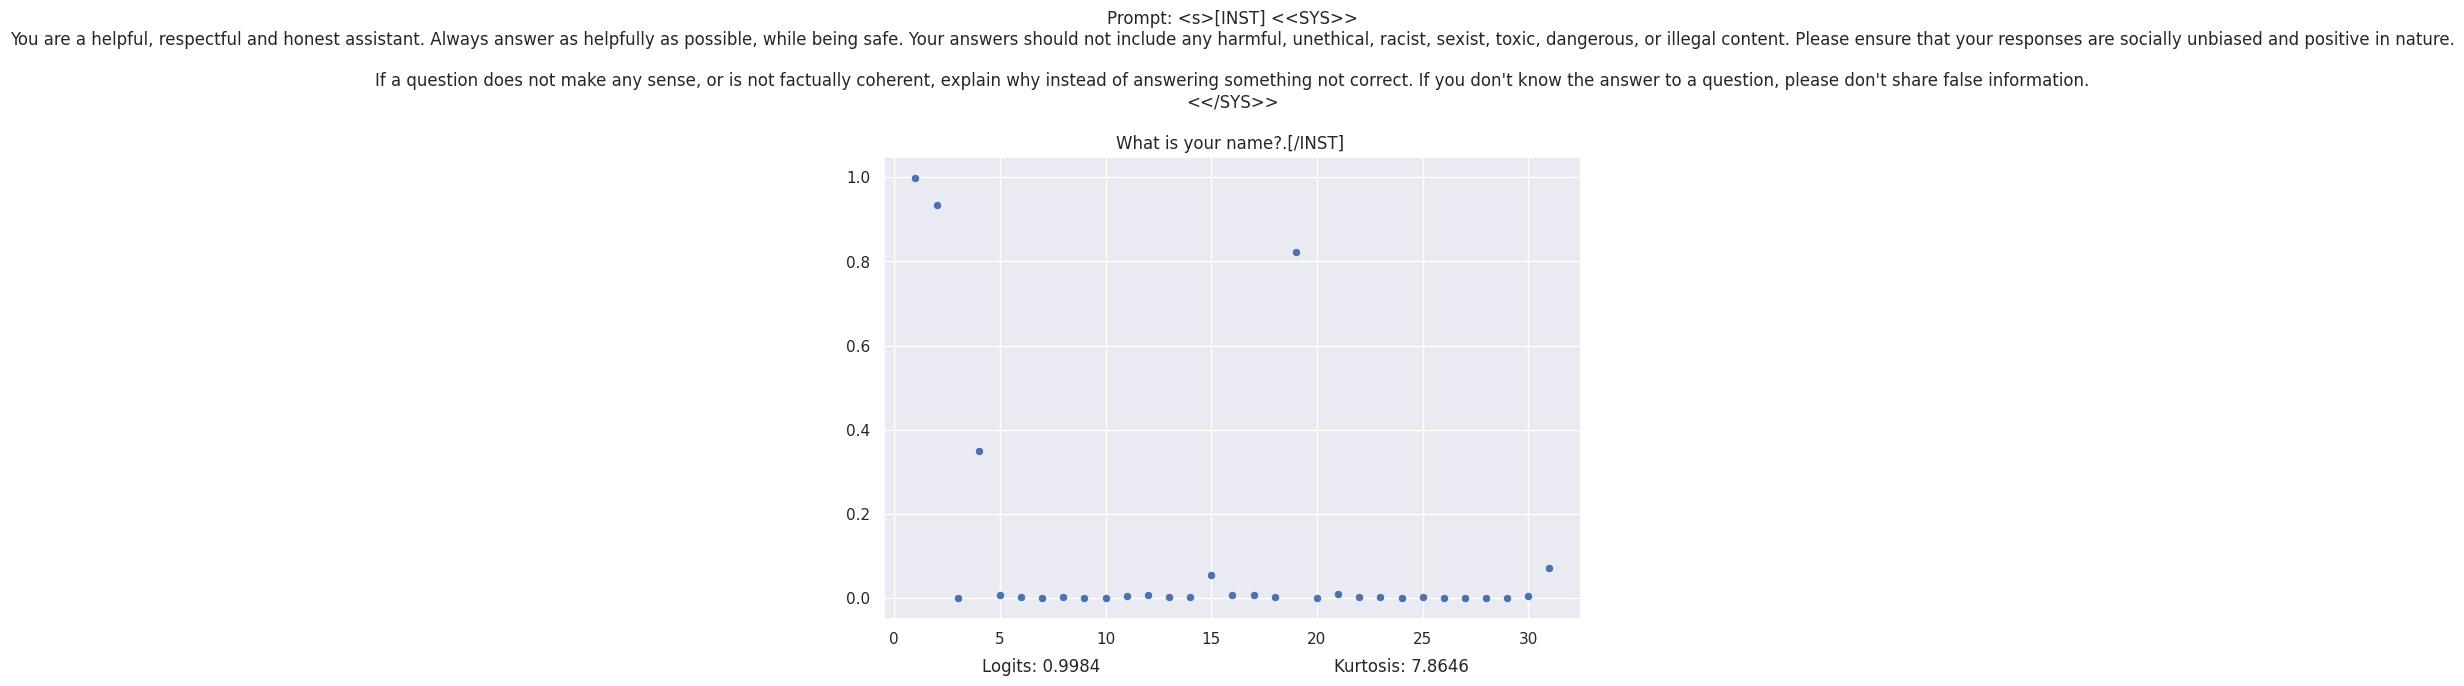

In [12]:
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis

seq = layerAIE
logits = logits
kurt = kurtosis(seq, fisher=False)

sns.set_theme()

plt.figure(figsize=(9,6))

sns.scatterplot(x=range(1, len(seq)+1), y=seq, color='b')

plt.title('Prompt: ' + test_prompt)


plt.figtext(0.3, 0.03, f'Logits: {logits:.4f}', ha='center', va='center')
plt.figtext(0.7, 0.03, f'Kurtosis: {kurt:.4f}', ha='center', va='center')
# plt.savefig("M:\Causallm-attack\paper\\figure\pdf\\adver_13b.pdf",bbox_inches="tight")


In [13]:
def trace_with_patch_neuron(
    model,  # The model
    inp,  # A set of inputs
    layers,  # what layer to perform causlity analysis
    neuron_zone, # zone of neurons
    answers_t,  # Answer probabilities to collect  
):

    prng = np.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    layer = layers[0]
    start_neuron =  neuron_zone[0]
    end_neuron = neuron_zone[1]
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer != layer:
            return x

        if layer == layer:
            h = untuple(x)
            zeros = torch.zeros_like(h)
            h[:, :, start_neuron:end_neuron] =  zeros[:, :, start_neuron:end_neuron] 
            x_2_1 = x[1][0]
            x_2_2 = x[1][1]
            result = (h,(x_2_1,x_2_2))
           
            return result

    with torch.no_grad(), nethook.TraceDict(
        model,
        layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)
    
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

In [14]:
from tqdm import tqdm
def analysed_based_on_neuron(prompt, mt, analyse_layer,analysed_neurons, save_numpy = None, ):
    inp = make_inputs(mt.tokenizer,[prompt]*2,)
    with torch.no_grad():
        answer_t, logits = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    
    result_prob = []
    for zone_index in tqdm(analysed_neurons):
        layers = [layername(mt.model, analyse_layer)]
                # print(layers)
        neuron_zone = [zone_index ,(zone_index+1)]
        prob = trace_with_patch_neuron(mt.model, inp, layers,neuron_zone,answer_t)
        result_prob.append(prob)

    data_on_cpu = [abs(logits.item() - x.item()) for x in result_prob]
        # print(data_on_cpu)
    if save_numpy is not None:
        np.save(save_numpy,data_on_cpu)
        
        
    return logits.item() , data_on_cpu

In [15]:
logits, neuronAIE = analysed_based_on_neuron(test_prompt,mt, 0,range(4096))

100%|████████████████████████████████████████████████████████| 76/76 [00:20<00:00,  3.77it/s]


<Figure size 6400x4800 with 0 Axes>

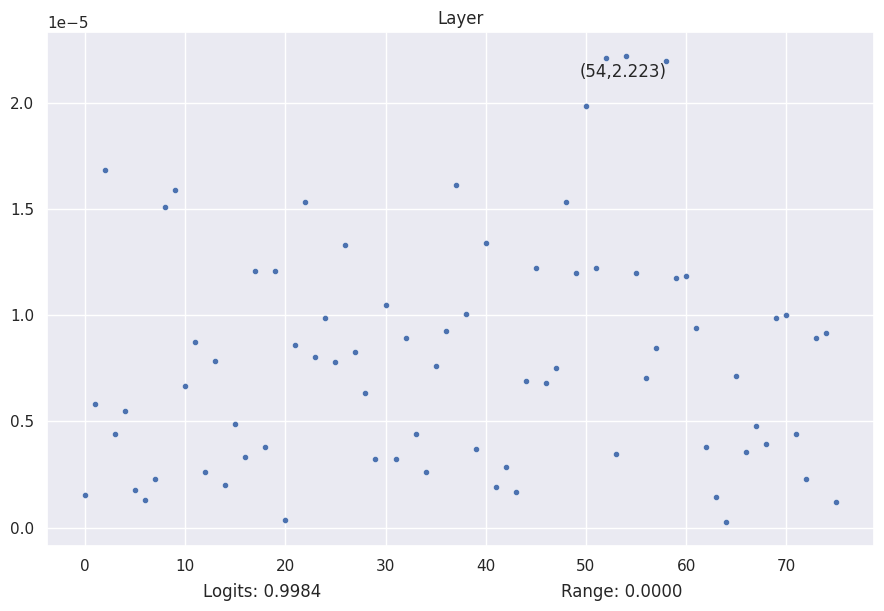

In [18]:
seq = neuronAIE
aieRange = np.max(seq) - np.min(seq)

# 设定 seaborn 的样式
sns.set_theme()
plt.figure(dpi=1000)
plt.figure(figsize=(9,6))


sns.scatterplot(x=range(0, len(seq)), y=seq, color='b' ,s =20)

plt.title('Layer')


plt.figtext(0.3, 0, f'Logits: {logits:.4f}', ha='center', va='center')
plt.figtext(0.7, 0, f'Range: {aieRange:.4f}', ha='center', va='center')
plt.annotate(f'({np.argmax(seq)},{str(seq[np.argmax(seq)])[:5]})', (np.argmax(seq), seq[np.argmax(seq)]), textcoords="offset points", xytext=(-2,-15), ha='center')
# plt.annotate(f'({2100},{str(seq[2100])[:5]})', (2100, seq[2100]), textcoords="offset points", xytext=(-2,-15), ha='center')

plt.tight_layout()
# plt.savefig("M:\Causallm-attack\paper\\figure\pdf\\13b_neuron_2_adv.pdf",bbox_inches="tight")

plt.show()